This code runs the Splines'n Lines model developed by David Kent, Tamás Budavári, Thomas J. Loredo and David Ruppert on quassar data from the Sloan Digital Sky Survey as understood by luminosity? 







The following cell reads all of the line profile information advailable. The purpose is to detect whether all files have the same recorded line profiles, whether information for particular line profiles might be missing, and to decide which line profiles to consider thereof. We will use the line profiles conatined on the "to\_use\_profiles" variable. If a galaxy where to have a 0 line width in one of the profiles of "to\_use\_profiles", it will be imputated by setting it to the mean line profile of its kind. 

Going for file 100
Going for file 200
Going for file 300
Going for file 400
Going for file 500
Going for file 600
Going for file 700
Nan values per column:   
 LINENAME         0
LINEWAVE         0
LINEZ            0
LINEZ_ERR        1
LINESIGMA        0
LINESIGMA_ERR    0
Z                0
file_name        0
dtype: int64
           LINENAME     LINEWAVE     LINEZ  LINEZ_ERR    LINESIGMA  \
4    b'C_III] 1908'  1908.734000  0.000000  -1.000000     0.000000   
2      b'C_IV 1549'  1549.480000  0.000000  -1.000000     0.000000   
27       b'H_alpha'  6564.613974  0.000421   0.000025    91.300972   
16        b'H_beta'  4862.683021  0.000421   0.000025    91.300972   
12       b'H_delta'  4102.891635  0.000421   0.000025    91.300972   
..              ...          ...       ...        ...          ...   
23    b'[O_I] 6300'  6302.046448 -0.001670   0.003476  7257.452637   
25    b'[O_I] 6363'  6365.535493 -0.001671   0.003476  7257.452637   
24  b'[S_III] 6312'  6313.805605 -0.001672   

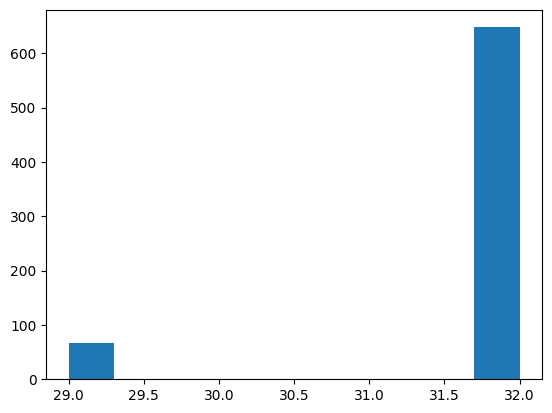

In [16]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
import pandas as pd
from astropy.table import Table 
from astropy.io import fits
import matplotlib.pyplot as plt 
import torch
import SplinesNLines


all_data = pd.read_csv('Selection2_les_astro_guapes.csv') #Reads record data. 
all_data = all_data.drop_duplicates(subset= ['sdss_id'])
file_names = all_data['sas_file'].to_list() #Places all file names in a list. 
f1 = file_names[0]

"""
Note: Line profile information is read first to see which line profile information is available and how it varies. 
"""
#Read information for line profiles-----------------------------------------------------------------------------------------------------------
cols = ['LINENAME', 'LINEWAVE', 'LINEZ', 'LINEZ_ERR', 'LINESIGMA', 'LINESIGMA_ERR' ]

f1 = file_names[0]
table_line = Table.read(f1, hdu = 4)
table_line = table_line.to_pandas()
table_line = table_line[cols]
curr_file_z = Table.read(f1, format = 'fits', hdu = 2) #Reads file with z
curr_z = curr_file_z[0]['Z'] #Obtaines redshift. 

table_line['Z'] = curr_z
table_line['file_name'] = f1

no_prof = [] #Array to store the number of profiles in each file. 

var = [] #Adds to array the names of the profiles of those files with 29 recorded profiles. 
max_lam =[] #Array to store the maximum recorded value of wavelength. 
min_lam = []  #Array to store the minimum recorded value of wavelength. 
var_pos = []

"""
Index(['PLATE', 'MJD', 'FIBERID', 'LINENAME', 'LINEWAVE', 'LINEZ', 'LINEZ_ERR',
       'LINESIGMA', 'LINESIGMA_ERR', 'LINEAREA', 'LINEAREA_ERR', 'LINEEW',
       'LINEEW_ERR', 'LINECONTLEVEL', 'LINECONTLEVEL_ERR', 'LINENPIXLEFT',
       'LINENPIXRIGHT', 'LINEDOF', 'LINECHI2'],
      dtype='object')
Index(['PLATE', 'MJD', 'FIBERID', 'LINENAME', 'LINEWAVE', 'LINEZ', 'LINEZ_ERR',
       'LINESIGMA', 'LINESIGMA_ERR', 'LINEAREA', 'LINEAREA_ERR', 'LINEEW',
       'LINEEW_ERR', 'LINECONTLEVEL', 'LINECONTLEVEL_ERR', 'LINENPIXLEFT',
       'LINENPIXRIGHT', 'LINEDOF', 'LINECHI2'],
      dtype='object')

"""

for i in range(1, len(file_names)):
    if i%100 == 0:
        print(f"Going for file {i}")

    oth_table = Table.read(file_names[i], hdu = 1).to_pandas()
    curr_file_z = Table.read(file_names[i], format = 'fits', hdu = 2) #Reads file with z
    curr_z = curr_file_z[0]['Z'] #Obtaines redshift. 
    try:
        curr_table = Table.read(file_names[i], hdu = 4).to_pandas()
        curr_table = curr_table[cols]
        log_lam_curr = 10**oth_table['LOGLAM']
    except:
        curr_table = Table.read(file_names[i], hdu = 3).to_pandas()
        curr_table = curr_table[cols]
        log_lam_curr = 10**oth_table['loglam']

    max_lam.append(log_lam_curr.max()/(1+curr_z)  )
    min_lam.append(log_lam_curr.min()/(1+curr_z)   )
    curr_table['Z'] = curr_z
         
    curr_table['file_name'] = len(curr_table)*[file_names[i]]
    if len(curr_table) == 29:
        var.append(curr_table['LINENAME'].to_list())
        var_pos.append(curr_table['LINEWAVE'].to_list())
    no_prof.append(len(curr_table))
    table_line = pd.concat([table_line, curr_table])

print("Nan values per column:   \n",   table_line.isnull().sum())
line_sd_mean = table_line.groupby('LINENAME')['LINESIGMA'].mean()

table_line = table_line.sort_values(['file_name','LINENAME'])
to_use_profiles = var[0]
print(table_line)

to_use_profiles = list(dict.fromkeys([(x.decode('utf-8').strip()).replace(' ', '') 
                                      if isinstance(x, bytes) else (x.strip()).replace(' ', '') for x in to_use_profiles
                                    ])) #Convert to_use_profiles elements to strings and remove spaces. 
table_line['LINENAME'] = table_line['LINENAME'].str.decode('utf-8') #Change the format from bytes to string. 
table_line['LINENAME'] = table_line['LINENAME'].str.replace(' ', '') #Replace all of spaces with empty strings. 


table_line = table_line[ (table_line['LINESIGMA'] > 0) & (table_line['LINENAME'].isin(to_use_profiles)) ] #Select only those with LINESIGMA> 0 and that 
                                                                                                          #correspond to LINENAME's that are going to be used. 

print(table_line.columns)
plt.hist(no_prof)
plt.show()
#-----------------------------------------------------------------------------------------------------------------------------------------------





In [17]:

unique_pairs = (table_line[['LINENAME', 'LINEWAVE']].drop_duplicates().groupby('LINENAME', as_index=False).agg(LINEWAVE=('LINEWAVE', 'mean')))
line_sig_mean = (table_line.groupby('LINENAME', as_index= False).agg(LINESIGMA = ('LINESIGMA', 'mean'))  )
line_df = unique_pairs.merge(line_sig_mean, on = 'LINENAME')

line_wave = np.sort(line_df['LINEWAVE'].to_numpy())



The cell below performs two tasks: 
1. Read each individual fits file
2. Create a line profile design matrix for each of the galaxies. If a value of a line profile is missing, it will be replaced by its mean. 
3. Create a B-Spline design matrix using the wavelength values. 





In [26]:


B_f = 20 #Sets number of B-Spline functions to use. 
m = 2 #Value such that m+1 is the degree of the basis B-Spline functions. 
L = len(to_use_profiles) #Sets number of line profiles. 
T = np.linspace(np.min(min_lam), np.max(max_lam), B_f + m + 2) #Sets equally spaced knots for B-Spline basis. 
                                                                 #Limits are based on the mean min_lam and max_lam values. 
to_use_profiles_set = set(to_use_profiles)
X_a = []
f_a = []
T_a = []
not_used = []

for o in range(len(file_names)):

    if o%100 == 0:
        print(f"Going for file {o}")

    f = file_names[o]
    curr_file = Table.read(f, hdu = 1).to_pandas() #Reads the .fits file corresponding to the Flux-wavelength data for f. 

    #For the current file, select those points without specified problems and with a stricty possitive precision parameter (IVAR).
    #The try-except helps to handle both .fits files from DR17 and DR19 without breaking the flow of execution. 
    try:
        curr_file = curr_file[(curr_file['AND_MASK'] == 0) & (curr_file['IVAR'] > 0)]
        tau_ok_name = 'IVAR'
        log_lam_name = 'LOGLAM'
        flux_name = 'FLUX'
        #curr_file_line = Table.read(f, hdu = 4).to_pandas()

    except:
        curr_file = curr_file[(curr_file['and_mask'] == 0) & (curr_file['ivar'] > 0)]
        tau_ok_name = 'ivar'
        log_lam_name = 'loglam'
        flux_name = 'flux'
        #curr_file_line = Table.open(f, hdu = 3).to_pandas()
    try:
        select_idx = [( (i+1)%np.ceil( len(curr_file)/1000) == 0  ) for i in range(len(curr_file)) ] #Reduces the number of points to use. 
        curr_file = curr_file[select_idx] #Selects the points to use. 

        aux = table_line[table_line['file_name'] == f]
        curr_z = aux['Z'].iloc[0]


        #line_prof_curr = table_line[table_line['file_name'] == f]#Selects the line profile information for f. 
        #line_prof_curr = line_prof_curr[['LINENAME', 'LINEWAVE', 'LINESIGMA']] 

        #missing_line_prof =  list(to_use_profiles_set - set(line_prof_curr['LINENAME'].to_list())) #Checks which line profiles are missing. 
        #if len(missing_line_prof) > 0:
        #    line_prof_curr = pd.concat([line_prof_curr, line_df[line_df['LINENAME'].isin(missing_line_prof)]])
        #line_prof_curr = line_prof_curr.sort_values('LINEWAVE')        
        Tau_ok = curr_file[tau_ok_name].to_numpy()
        To = (10**(curr_file[log_lam_name].to_numpy()))/(1 + curr_z)
        X_B = SplinesNLines.get_basis_mat_B_Spline_opt(To, B_f, m, T)
        #X_L = SplinesNLines.eval_Line_Profiles_opt(To, line_wave, line_prof_curr['LINESIGMA'].to_numpy() ) #Falta width values
        fo = (curr_file[flux_name].to_numpy()).reshape(-1,1)
        X_a.append(X_B)
        #X_a.append(np.hstack((X_B, X_L)))
        T_a.append(np.diag(curr_file[tau_ok_name].to_numpy()))
        f_a.append(fo)
    except:
        print(f"Error on file {f}. \n Moving on...")
        not_used.append(f)



    




Going for file 0
Going for file 100
Going for file 200
Going for file 300
Going for file 400
Going for file 500
Going for file 600
Error on file spec-7881-57282-0453.fits. 
 Moving on...
Going for file 700


In [27]:
#del table_line, curr_file, curr_table
A = SplinesNLines.get_mat_comp(X_a, f_a, T_a)
del X_a, f_a, T_a 
L = SplinesNLines.EM_alg(A['XtXf'], A['XtTX'], n_max = 10000, tol = 1e-10)
mu_h = L['mu_h']
S_h = L['S_h']


Iteration:   0


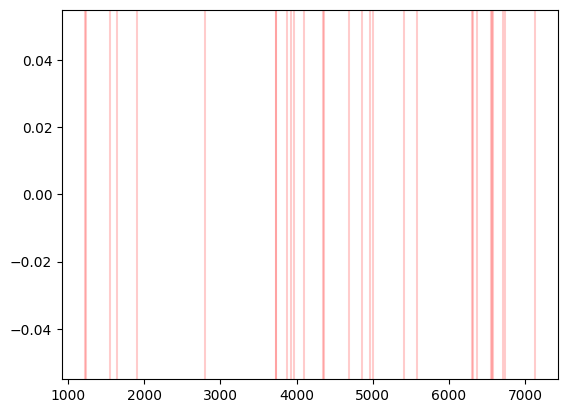

In [28]:

T_mu = np.linspace(np.mean(min_lam), np.mean(max_lam), num = 1000)
X_mu = SplinesNLines.get_basis_mat_B_Spline_opt(T_mu, B_f, m, T)
mu = torch.from_numpy(X_mu)@mu_h
plt.plot(T_mu, mu)

for lw in line_wave:
    plt.axvline(x = lw, color = 'red', alpha = 0.2)

plt.show()

In [ ]:
B_f = 63 #Sets number of B-Spline functions to use. 
m = 2 #Value such that m+1 is the degree of the basis B-Spline functions. 
L = len(to_use_profiles) #Sets number of line profiles. 
T = np.linspace(np.min(min_lam), np.max(max_lam), B_f + m + 2) #Sets equally spaced knots for B-Spline basis. 
                                                                 #Limits are based on the mean min_lam and max_lam values. 
to_use_profiles_set = set(to_use_profiles)
X_a = []
f_a = []
T_a = []
not_used = []

for o in range(len(file_names)):
    if o%100 == 0:
        print(f"Going for file {o}")

    f = file_names[o]
    curr_file = Table.read(f, hdu = 1).to_pandas() #Reads the .fits file corresponding to the Flux-wavelength data for f. 

    #For the current file, select those points without specified problems and with a stricty possitive precision parameter (IVAR).
    #The try-except helps to handle both .fits files from DR17 and DR19 without breaking the flow of execution. 
    try:
        curr_file = curr_file[(curr_file['AND_MASK'] == 0) & (curr_file['IVAR'] > 0)]
        tau_ok_name = 'IVAR'
        log_lam_name = 'LOGLAM'
        flux_name = 'FLUX'
        #curr_file_line = Table.read(f, hdu = 4).to_pandas()

    except:
        curr_file = curr_file[(curr_file['and_mask'] == 0) & (curr_file['ivar'] > 0)]
        tau_ok_name = 'ivar'
        log_lam_name = 'loglam'
        flux_name = 'flux'
        #curr_file_line = Table.open(f, hdu = 3).to_pandas()


    try:
        select_idx = [( (i+1)%np.ceil( len(curr_file)/1000) == 0  ) for i in range(len(curr_file)) ] #Reduces the number of points to use. 
        curr_file = curr_file[select_idx] #Selects the points to use. 
        aux = table_line[table_line['file_name'] == f]
        curr_z = aux['Z'][0]
        #line_prof_curr = table_line[table_line['file_name'] == f]#Selects the line profile information for f. 
        #line_prof_curr = line_prof_curr[['LINENAME', 'LINEWAVE', 'LINESIGMA']] 

        #missing_line_prof =  list(to_use_profiles_set - set(line_prof_curr['LINENAME'].to_list())) #Checks which line profiles are missing. 
        #if len(missing_line_prof) > 0:
        #    line_prof_curr = pd.concat([line_prof_curr, line_df[line_df['LINENAME'].isin(missing_line_prof)]])
        #line_prof_curr = line_prof_curr.sort_values('LINEWAVE')        
        Tau_ok = curr_file[tau_ok_name].to_numpy()
        To = (10**(curr_file[log_lam_name].to_numpy()))/(1 + curr_z)
        X_B = SplinesNLines.get_basis_mat_B_Spline_opt(To, B_f, m, T)
        #X_L = SplinesNLines.eval_Line_Profiles_opt(To, line_wave, line_prof_curr['LINESIGMA'].to_numpy() ) #Falta width values
        fo = (curr_file[flux_name].to_numpy()).reshape(-1,1)
        X_a.append(X_B)
        #X_a.append(np.hstack((X_B, X_L)))
        T_a.append(np.diag(curr_file[tau_ok_name].to_numpy()))
        f_a.append(fo)
    except:
        print(f"Error on file {f}. \n Moving on...")
        not_used.append(f)



    




Going for file 0
Going for file 100
Going for file 200
Going for file 300
Going for file 400
Going for file 500
Going for file 600
Error on file spec-7881-57282-0453.fits. 
 Moving on...
Going for file 700


715
Iteration:   0
Iteration:   1000
Iteration:   2000
Iteration:   3000
Iteration:   4000
Iteration:   5000
Iteration:   6000
Iteration:   7000
Iteration:   8000
Iteration:   9000


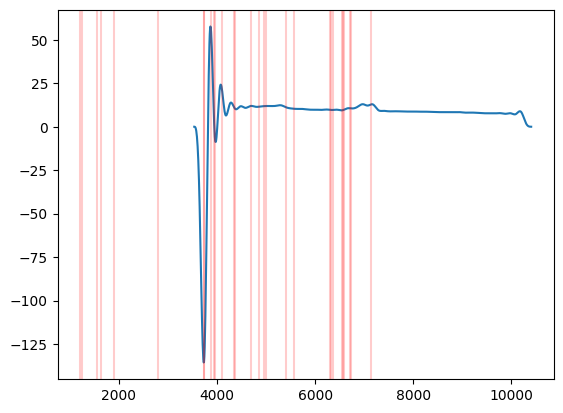

In [9]:

print(len(f_a))
#del table_line, curr_file, curr_table
A = SplinesNLines.get_mat_comp(X_a, f_a, T_a)
#del X_a, f_a, T_a 
L = SplinesNLines.EM_alg(A['XtXf'], A['XtTX'], n_max = 10000, tol = 1e-10)
mu_h = L['mu_h']
S_h = L['S_h']

T_mu = np.linspace(np.min(min_lam), np.max(max_lam), num = 1000)
X_mu = SplinesNLines.get_basis_mat_B_Spline_opt(T_mu, B_f, m, T)
mu = torch.from_numpy(X_mu)@mu_h
plt.plot(T_mu, mu)

for lw in line_wave:
    plt.axvline(x = lw, color = 'red', alpha = 0.2)

plt.show()


In [1]:
import pandas as pd
#del X_a, f_a, T_a 

all_line_data = {
    'LINEWAVE': [1215.67, 1240.81, 1549.48, 1640.42, 1908.734, 2800.3152, 3727.0917, 
                 3729.8754, 3869.8568, 3890.1511, 3971.1232, 4102.8916, 4341.6843, 
                 4364.4353, 4686.9915, 4862.6830, 4960.2949, 5008.2397, 5413.0245, 
                 5578.8878, 5756.1862, 5877.3086, 6302.0464, 6363.776, 6313.8056, 
                 6365.5355, 6549.8590, 6564.6140, 6585.2685, 6718.2943, 6732.6782, 
                 7137.7572],
    'LINENAME': ['Ly_alpha', 'N_V 1240', 'C_IV 1549', 'He_II 1640', 'C_III] 1908', 
                 'Mg_II 2799', '[O_II] 3725', '[O_II] 3727', '[Ne_III] 3868', 
                 'H_epsilon', '[Ne_III] 3970', 'H_delta', 'H_gamma', '[O_III] 4363', 
                 'He_II 4685', 'H_beta', '[O_III] 4959', '[O_III] 5007', 'He_II 5411', 
                 '[O_I] 5577', '[N_II] 5755', 'He_I 5876', '[O_I] 6300', '[O_I] 6363', 
                 '[S_III] 6312', '[O_I] 6363', '[N_II] 6548', 'H_alpha', '[N_II] 6583', 
                 '[S_II] 6716', '[S_II] 6730', '[Ar_III] 7135'],
    'ZINDEX': ['z_lya', 'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission'],
    'WINDEX': ['w_ly_a', 'w_n_v', 'wemission', 'wemission', 'wemission', 'wemission', 
               'wemission', 'wemission', 'wemission', 'w_balmer', 'wemission', 
               'w_balmer', 'wemission', 'wemission', 'wemission', 'w_balmer', 
               'wemission', 'wemission', 'wemission', 'wemission', 'wemission', 
               'wemission', 'wemission', 'wemission', 'wemission', 'wemission', 
               'wemission', 'w_balmer', 'wemission', 'wemission', 'wemission', 
               'wemission']
}

all_line_data = pd.DataFrame(all_line_data)
line_data_use = all_line_data[(all_line_data['LINEWAVE'] > np.min(min_lam)) & (all_line_data['LINEWAVE'] < np.max(max_lam))]

B_f = 63 #Sets number of B-Spline functions to use. 
m = 2 #Value such that m+1 is the degree of the basis B-Spline functions. Needs: B_f + m + 2 knots. 
T = np.sort( np.concatenate([line_data_use['LINEWAVE'].to_numpy(), np.linspace(np.min(min_lam), np.max(max_lam), B_f + m + 2 - len(line_data_use['LINEWAVE'].to_numpy())   )  ]    ))





NameError: name 'np' is not defined

In [ ]:

to_use_profiles_set = set(to_use_profiles)
X_a2 = []
f_a2 = []
T_a2 = []
not_used = []

for o in range(len(file_names)):
    if o%100 == 0:
        print(f"Going for file {o}")
        
    f = file_names[o]
    curr_file = Table.read(f, hdu = 1).to_pandas() #Reads the .fits file corresponding to the Flux-wavelength data for f. 

    #For the current file, select those points without specified problems and with a stricty possitive precision parameter (IVAR).
    #The try-except helps to handle both .fits files from DR17 and DR19 without breaking the flow of execution. 
    try:
        curr_file = curr_file[(curr_file['AND_MASK'] == 0) & (curr_file['IVAR'] > 0)]
        tau_ok_name = 'IVAR'
        log_lam_name = 'LOGLAM'
        flux_name = 'FLUX'
        #curr_file_line = Table.read(f, hdu = 4).to_pandas()

    except:
        curr_file = curr_file[(curr_file['and_mask'] == 0) & (curr_file['ivar'] > 0)]
        tau_ok_name = 'ivar'
        log_lam_name = 'loglam'
        flux_name = 'flux'
        #curr_file_line = Table.open(f, hdu = 3).to_pandas()


    try:
        select_idx = [( (i+1)%np.ceil( len(curr_file)/1000) == 0  ) for i in range(len(curr_file)) ] #Reduces the number of points to use. 
        curr_file = curr_file[select_idx] #Selects the points to use. 
        aux = table_line[table_line['file_name'] == f]
        curr_z = aux['Z'][0]
        #line_prof_curr = table_line[table_line['file_name'] == f]#Selects the line profile information for f. 
        #line_prof_curr = line_prof_curr[['LINENAME', 'LINEWAVE', 'LINESIGMA']] 

        #missing_line_prof =  list(to_use_profiles_set - set(line_prof_curr['LINENAME'].to_list())) #Checks which line profiles are missing. 
        #if len(missing_line_prof) > 0:
        #    line_prof_curr = pd.concat([line_prof_curr, line_df[line_df['LINENAME'].isin(missing_line_prof)]])
        #line_prof_curr = line_prof_curr.sort_values('LINEWAVE')        
        Tau_ok = curr_file[tau_ok_name].to_numpy()
        To = (10**(curr_file[log_lam_name].to_numpy()))/(1 + curr_z)
        X_B = SplinesNLines.get_basis_mat_B_Spline_opt(To, B_f, m, T)
        #X_L = SplinesNLines.eval_Line_Profiles_opt(To, line_wave, line_prof_curr['LINESIGMA'].to_numpy() ) #Falta width values
        fo = (curr_file[flux_name].to_numpy()).reshape(-1,1)
        X_a2.append(X_B)
        #X_a.append(np.hstack((X_B, X_L)))
        T_a2.append(np.diag(curr_file[tau_ok_name].to_numpy()))
        f_a2.append(fo)
    except:
        print(f"Error on file {f}. \n Moving on...")
        not_used.append(f)



    




Going for file 0
Going for file 100
Going for file 200
Going for file 300
Going for file 400
Going for file 500
Going for file 600
Error on file spec-7881-57282-0453.fits. 
 Moving on...
Going for file 700


In [14]:

#del table_line, curr_file, curr_table
A = SplinesNLines.get_mat_comp(X_a2, f_a2, T_a2)
del X_a2, f_a2, T_a2 
L = SplinesNLines.EM_alg(A['XtXf'], A['XtTX'], n_max = 10000, tol = 1e-10)
mu_h = L['mu_h']
S_h = L['S_h']




Iteration:   0
Iteration:   1000
Iteration:   2000
Iteration:   3000
Iteration:   4000
Iteration:   5000
Iteration:   6000
Iteration:   7000
Iteration:   8000
Iteration:   9000


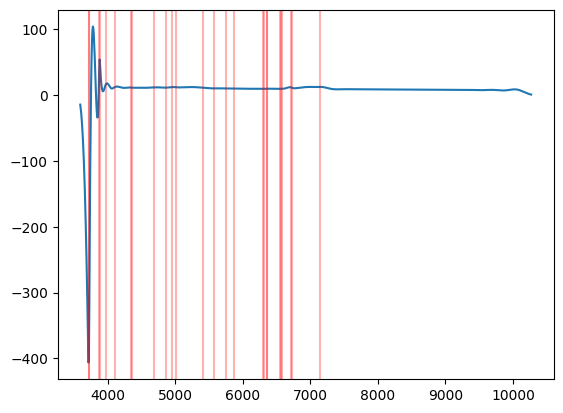

In [15]:
T_mu = np.linspace(np.mean(min_lam), np.mean(max_lam), num = 1000)
X_mu = SplinesNLines.get_basis_mat_B_Spline_opt(T_mu, B_f, m, T)
mu = torch.from_numpy(X_mu)@mu_h

line_data_use['LINEWAVE'].to_numpy()
plt.plot(T_mu, mu)

for lw in line_data_use['LINEWAVE'].to_numpy():
    plt.axvline(x = lw, color = 'red', alpha = 0.3)

plt.show()

In [30]:
import SplinesNLines 
B_f = 70 #Sets number of B-Spline functions to use. 
m = 2 #Value such that m+1 is the degree of the basis B-Spline functions. Needs: B_f + m + 2 knots. 
T = np.sort( np.concatenate([line_data_use['LINEWAVE'].to_numpy(), np.linspace(np.min(min_lam), np.max(max_lam), B_f + m + 2 - len(line_data_use['LINEWAVE'].to_numpy())   )  ]    ))
T = np.linspace( np.min(min_lam), np.max(max_lam), B_f + m + 2)

to_use_profiles_set = set(to_use_profiles)
X_a3 = []
f_a3 = []
T_a3 = []
not_used = []

for o in range(len(file_names)):
    if o%100 == 0:
        print(f"Going for file {o}")

    f = file_names[o]
    curr_file = Table.read(f, hdu = 1).to_pandas() #Reads the .fits file corresponding to the Flux-wavelength data for f. 

    #For the current file, select those points without specified problems and with a stricty possitive precision parameter (IVAR).
    #The try-except helps to handle both .fits files from DR17 and DR19 without breaking the flow of execution. 
    try:
        curr_file = curr_file[(curr_file['AND_MASK'] == 0) & (curr_file['IVAR'] > 0)]
        tau_ok_name = 'IVAR'
        log_lam_name = 'LOGLAM'
        flux_name = 'FLUX'
        #curr_file_line = Table.read(f, hdu = 4).to_pandas()

    except:
        curr_file = curr_file[(curr_file['and_mask'] == 0) & (curr_file['ivar'] > 0)]
        tau_ok_name = 'ivar'
        log_lam_name = 'loglam'
        flux_name = 'flux'
        #curr_file_line = Table.open(f, hdu = 3).to_pandas()


    try:
        select_idx = [( (i+1)%np.ceil( len(curr_file)/1000) == 0  ) for i in range(len(curr_file)) ] #Reduces the number of points to use. 
        curr_file = curr_file[select_idx] #Selects the points to use.
        aux = table_line[table_line['file_name'] == f]
        curr_z = aux['Z'].iloc[0]
        #line_prof_curr = table_line[table_line['file_name'] == f]#Selects the line profile information for f. 
        #line_prof_curr = line_prof_curr[['LINENAME', 'LINEWAVE', 'LINESIGMA']] 

        #missing_line_prof =  list(to_use_profiles_set - set(line_prof_curr['LINENAME'].to_list())) #Checks which line profiles are missing. 
        #if len(missing_line_prof) > 0:
        #    line_prof_curr = pd.concat([line_prof_curr, line_df[line_df['LINENAME'].isin(missing_line_prof)]])
        #line_prof_curr = line_prof_curr.sort_values('LINEWAVE')        
        Tau_ok = curr_file[tau_ok_name].to_numpy()
        To = (10**(curr_file[log_lam_name].to_numpy()))/(1 + curr_z)
        X_B = SplinesNLines.get_basis_mat_B_Spline_opt(To, B_f, m, T)
        #X_L = SplinesNLines.eval_Line_Profiles_opt(To, line_wave, line_prof_curr['LINESIGMA'].to_numpy() ) #Falta width values
        fo = (curr_file[flux_name].to_numpy()).reshape(-1,1)
        X_a3.append(X_B)
        #X_a.append(np.hstack((X_B, X_L)))
        T_a3.append(np.diag(curr_file[tau_ok_name].to_numpy()))
        f_a3.append(fo)
    except:
        print(f"Error on file {f}. \n Moving on...")
        not_used.append(f)



    




Going for file 0
Going for file 100
Going for file 200
Going for file 300
Going for file 400
Going for file 500
Going for file 600
Error on file spec-7881-57282-0453.fits. 
 Moving on...
Going for file 700


Iteration:   0


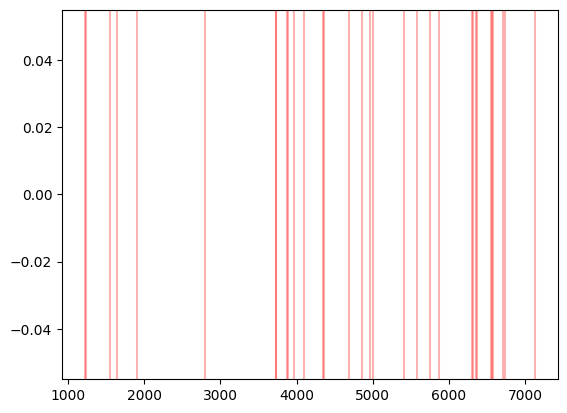

In [31]:
import torch 
A = SplinesNLines.get_mat_comp(X_a3, f_a3, T_a3)
del X_a3, f_a3, T_a3 
L = SplinesNLines.EM_alg(A['XtXf'], A['XtTX'], n_max = 10000, tol = 1e-10)
mu_h = L['mu_h']
S_h = L['S_h']

T_mu = np.linspace(np.mean(min_lam), np.mean(max_lam), num = 1000)
X_mu = SplinesNLines.get_basis_mat_B_Spline_opt(T_mu, B_f, m, T)
mu = torch.from_numpy(X_mu)@mu_h

line_data_use['LINEWAVE'].to_numpy()
plt.plot(T_mu, mu)

for lw in line_data_use['LINEWAVE'].to_numpy():
    plt.axvline(x = lw, color = 'red', alpha = 0.3)

plt.show()